In [430]:
import numpy
import pandas as pd
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler


In [431]:
df=pd.read_csv('12_18.csv')
#this csv file contains non normalized data speeds as standard scaler takes care of it later
df.columns=['Operator', 'Technology', 'Test_Type', 'Data_Speed','Signal_Strength', 'LSA']
df['Test_Type']=df['Test_Type'].str.lower()
df['LSA']=df['LSA'].fillna(method='ffill')
df['Signal_Strength']=df['Signal_Strength'].dropna()
df['Signal_Strength']=df['Signal_Strength'].transform(lambda value : -1*value if (value>0) else value)
df.head()

,Operator,Technology,Test_Type,Data_Speed,Signal_Strength,LSA
0,JIO,4G,download,7994,-109.0,Tamil Nadu
1,JIO,4G,download,10415,-108.0,Tamil Nadu
2,JIO,4G,download,6871,-110.0,Tamil Nadu
3,JIO,4G,download,3289,-109.0,Tamil Nadu
4,JIO,4G,download,3499,-110.0,Tamil Nadu


In [433]:
df=df.dropna()
df=df.drop(['Operator', 'Technology', 'Test_Type','LSA'], axis=1)
df.head()

,Data_Speed,Signal_Strength
0,7994,-109.0
1,10415,-108.0
2,6871,-110.0
3,3289,-109.0
4,3499,-110.0


In [434]:
def MyDBSCAN(D, eps, MinPts):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps)
        
        # If the number is below MinPts, this point is noise. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels


def growCluster(D, labels, P, NeighborPts, C, eps, MinPts):
    """
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    """

    # Assign the cluster label to the seed point.
    labels[P] = C
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionQuery(D, Pn, eps)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def regionQuery(D, P, eps):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if numpy.linalg.norm(D[P] - D[Pn]) < eps:
           neighbors.append(Pn)
            
    return neighbors

In [446]:
#Since we are taking sample of small size it is desirable to take multiple runs and obtain an average for the silhoutte score
sum=0
for i in range(50):
    smpl = df.sample(frac =.000265)
    X=smpl.iloc[:,:].values
    X = StandardScaler().fit_transform(X)
    X_DF = pd.DataFrame(X)
    X_DF.columns = ['P1', 'P2']
    db = DBSCAN(eps=0.4, min_samples=9).fit(X_DF)
    labels1=db.labels_
    sum+= metrics.silhouette_score(X, labels1)
sum=sum/100
print("Average Silhouette Coefficient: %0.3f" % sum)

Average Silhouette Coefficient: 0.267


In [447]:
smpl = df.sample(frac =.000265)
smpl.shape

(200, 2)

In [448]:
#preparing variables for both MyDBSCAN and DBSCAN
X=smpl.iloc[:,:].values
X = StandardScaler().fit_transform(X)
X_DF = pd.DataFrame(X)
X_DF.columns = ['P1', 'P2'] 
print(X_DF.head()) 

         P1        P2
0 -0.593646 -0.418425
1 -0.522428 -1.030158
2 -0.484630 -1.091332
3 -0.237942 -0.968985
4 -0.633891 -1.274852


Running MyDBSCAN and DBSCAN to compare results 

In [449]:
labels=MyDBSCAN(X,0.4,9)
labels = numpy.array(labels) 
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
labels.max()

Silhouette Coefficient: 0.560


1

In [450]:
db = DBSCAN(eps=0.4, min_samples=9).fit(X_DF)
labels1=db.labels_
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels1))
labels1.max()

Silhouette Coefficient: 0.560


0

In [451]:
# Scikit learn uses -1 to for NOISE, and starts cluster labeling at 0. I start
# numbering at 1, so increment the skl cluster numbers by 1.
for i in range(0, len(labels1)):
    if not labels1[i] == -1:
        labels1[i] += 1


###############################################################################
# Did we get the same results?

num_disagree = 0

# Go through each label and make sure they match (print the labels if they 
# don't)
for i in range(0, len(labels1)):
    if not labels1[i] == labels[i]:
        print('Scikit learn:', labels1[i], 'mine:', labels[i])
        num_disagree += 1

if num_disagree == 0:
    print('PASS - All labels match!')
else:
    print('FAIL -', num_disagree, 'labels don\'t match.') 

PASS - All labels match!


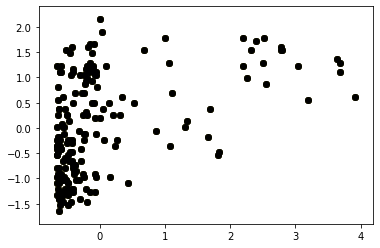

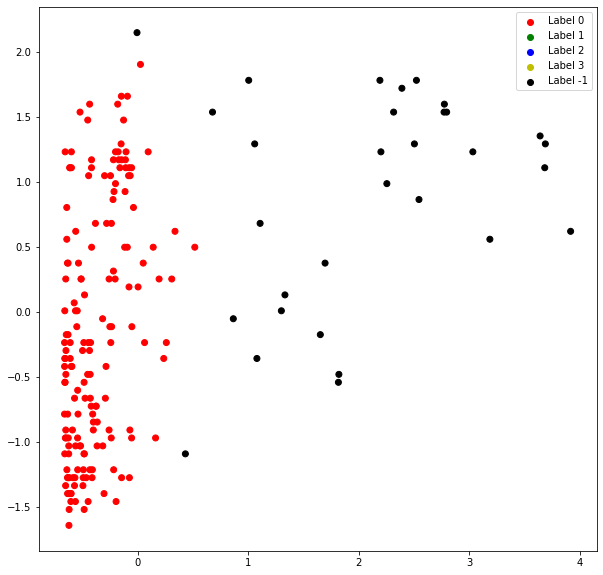

In [452]:
# Building the label to colour mapping 
colours = {} 
colours[1] = 'r'
colours[2] = 'g'
colours[3] = 'b'
colours[4] = 'y'
colours[-1] = 'k'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# For the construction of the legend of the plot 
r = plt.scatter(X_DF['P1'], X_DF['P2'], color ='r'); 
g = plt.scatter(X_DF['P1'], X_DF['P2'], color ='g');
b = plt.scatter(X_DF['P1'], X_DF['P2'], color ='b');
y = plt.scatter(X_DF['P1'], X_DF['P2'], color ='y');
k = plt.scatter(X_DF['P1'], X_DF['P2'], color ='k');

# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
plt.figure(figsize =(10,10)) 
plt.scatter(X_DF['P1'], X_DF['P2'],c = cvec)
# Building the legend 
plt.legend((r, g, b, y, k), ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label -1')) 
plt.show() 